# Reinforcement learning: Monte Carlo
Classes and functions created in the previous notebook are imported with the required libraries.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from UAH007_02_01_Dynamic_programming import Grid, create_grid, print_value_policy, print_policy, random_policy

%config InlineBackend.figure_format = 'retina'


## Modify politicy in a windy world

In the first place, a function to modify the policy in a world with wind will be created. This function will generate a random number and when the probability is higher than a threshold instead of moving according to the policy it moves randomly in any other direction.

In [7]:
def random_windy(a, windy=0.5, possible_actions=('U', 'D', 'L', 'R')):
    p = np.random.random()

    if p > windy:
        return a
    else:
        actions = list(possible_actions)
        
        if a  in actions:
            actions.remove(a)
            
        return np.random.choice(actions)

## Monte Carlo
A function that plays the game on the board and returns a list of states and returns is implemented.

First, it is necessary to restart the game to start at a random position. This must be done to evaluate the states in the cell in which the polity never go.

The game is played and the states are saved in a tuple of reward and states. Returns are calculated by backward programming.

In [8]:
def play_game(grid, policy, windy=0, gamma=0.9):

    # Restart the game to start at a random position
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])

    s = grid.current_state()
    states_and_rewards = [(s, 0)]
    while not grid.game_over():
        a = policy[s]
        a = random_windy(a, windy, grid.actions[s])
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s, r))

    # Calculation of the returns, the value of the terminal state is 0 by definition
    G = 0
    states_and_returns = []
    first = True

    for s, r in reversed(states_and_rewards):
        # It must ignore the first state and the last G since it does not correspond
        # to any movement
        if first:
            first = False
        else:
            states_and_returns.append((s, G))
        G = r + gamma*G

    # The states are rearranged
    states_and_returns.reverse()

    return states_and_returns

Now board and a policy to evaluate the value function using the Monte Carlo method can create.

In [9]:
grid = create_grid()
policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U'}

print_policy(policy, grid)

---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  →  |     |
---------------------------
  ↑  |  →  |  →  |  ↑  |


A function to initialize the values and returns can create.

In [10]:
def init_v_returns():
    V = {}
    returns = {}
    states = grid.all_states()
    for s in states:
        if s in grid.actions:
            returns[s] = []
        else:
            V[s] = 0

    return V, returns

Once the policy is defined, it can be evaluated.

In [11]:
V, returns = init_v_returns()

for t in range(5000):
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
        # Solamente se evalúa la primera visita
        if s not in seen_states:
            returns[s].append(G)
            V[s] = np.mean(returns[s])
            seen_states.add(s)

print_value_policy(V, policy, grid)

Value function
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|

Policy
---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  →  |     |
---------------------------
  ↑  |  →  |  →  |  ↑  |


The exercise with wind can repeat.

In [12]:
V, returns = init_v_returns()

for t in range(5000):
    states_and_returns = play_game(grid, policy, windy=0.5)
    seen_states = set()
    for s, G in states_and_returns:
        # Only the first visit is evaluated
        if s not in seen_states:
            returns[s].append(G)
            V[s] = np.mean(returns[s])
            seen_states.add(s)

print_value_policy(V, policy, grid)

Value function
---------------------------
 0.11| 0.24| 0.45| 0.00|
---------------------------
-0.01| 0.00|-0.53| 0.00|
---------------------------
-0.14|-0.31|-0.53|-0.73|

Policy
---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  →  |     |
---------------------------
  ↑  |  →  |  →  |  ↑  |


The exercise with another policy can repeat.

In [14]:
policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L'}

print_policy(policy, grid)

---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  ↑  |     |
---------------------------
  ↑  |  ←  |  ↑  |  ←  |


In [9]:
V, returns = init_v_returns()

for t in range(5000):
    states_and_returns = play_game(grid, policy, windy=0.5)
    seen_states = set()
    for s, G in states_and_returns:
        # Only the first visit is evaluated
        if s not in seen_states:
            returns[s].append(G)
            V[s] = np.mean(returns[s])
            seen_states.add(s)

print_value_policy(V, policy, grid)

Value function
---------------------------
 0.18| 0.32| 0.55| 0.00|
---------------------------
 0.09| 0.00|-0.05| 0.00|
---------------------------
 0.01|-0.09|-0.17|-0.58|

Policy
---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  ↑  |     |
---------------------------
  ↑  |  ←  |  ↑  |  ←  |


## Montecarlo_ES

In [15]:
def play_game_es(grid, policy, gamma=0.9):

    # Restart the game to start at a random position
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])

    s = grid.current_state()

    # The first action is random
    a = np.random.choice(Grid.possible_actions)

    # A triplet of actions and rewards states is created.
    states_actions_rewards = [(s, a, 0)]
    seen_states = set()
    seen_states.add(grid.current_state())
    num_steps = 0
    while True:
        r = grid.move(a)
        num_steps += 1
        s = grid.current_state()

        if s in seen_states:
            # In order not to end up in an infinite episode this penalty is
            # added for falling on the wall.
            reward = -10. / num_steps
            states_actions_rewards.append((s, None, reward))
            break
        elif grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = policy[s]
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)

    # Calculation of the returns, the value of the terminal state is 0 by definition
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + gamma*G

    states_actions_returns.reverse()

    return states_actions_returns

It is necessary to recover the maximum value of the dictionary, for this a function is created.

In [11]:
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

Like before it can be created a function to initialize the states.

In [16]:
def init_q_returns(grid):
    Q = {}
    returns = {}
    states = grid.all_states()
    for s in states:
        if s in grid.actions:
            Q[s] = {}
            for a in Grid.possible_actions:
                Q[s][a] = 0
                returns[(s, a)] = []
        else:
            pass

    return Q, returns

In [17]:
init_q_returns(grid)

({(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
  (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}},
 {((0, 0), 'U'): [],
  ((0, 0), 'D'): [],
  ((0, 0), 'L'): [],
  ((0, 0), 'R'): [],
  ((2, 1), 'U'): [],
  ((2, 1), 'D'): [],
  ((2, 1), 'L'): [],
  ((2, 1), 'R'): [],
  ((2, 3), 'U'): [],
  ((2, 3), 'D'): [],
  ((2, 3), 'L'): [],
  ((2, 3), 'R'): [],
  ((1, 0), 'U'): [],
  ((1, 0), 'D'): [],
  ((1, 0), 'L'): [],
  ((1, 0), 'R'): [],
  ((0, 1), 'U'): [],
  ((0, 1), 'D'): [],
  ((0, 1), 'L'): [],
  ((0, 1), 'R'): [],
  ((1, 2), 'U'): [],
  ((1, 2), 'D'): [],
  ((1, 2), 'L'): [],
  ((1, 2), 'R'): [],
  ((2, 0), 'U'): [],
  ((2, 0), 'D'): [],
  ((2, 0), 'L'): [],
  ((2, 0), 'R'): [],
  ((2, 2), 'U')

To evaluate the method a random policy is created.

In [13]:
grid = create_grid(step_cost=-0.1)
policy = random_policy(grid)

print_policy(policy, grid)

---------------------------
  →  |  →  |  ↓  |     |
---------------------------
  ↑  |     |  →  |     |
---------------------------
  ↑  |  ←  |  ↑  |  ↑  |


In [2]:
random_policy(grid)

NameError: name 'random_policy' is not defined

Now is is possible to iterate.

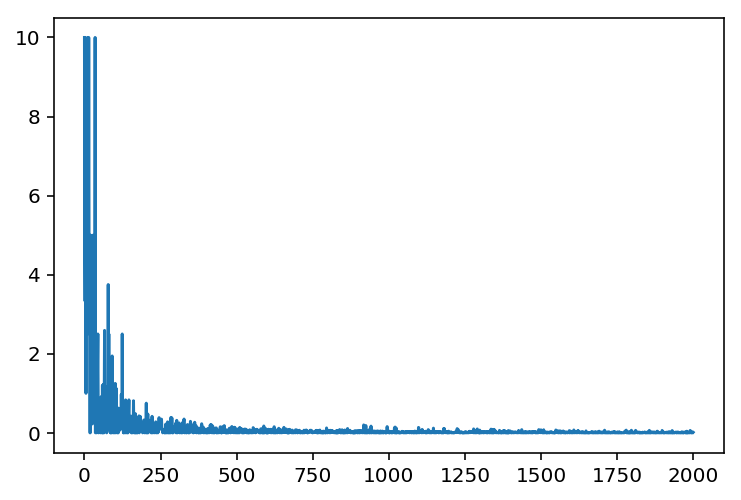

Value function
---------------------------
-0.56|-0.43| 1.00| 0.00|
---------------------------
-1.44| 0.00|-0.11| 0.00|
---------------------------
-1.22|-1.03|-0.29|-1.00|

Policy
---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  ↑  |     |
---------------------------
  ↑  |  →  |  ↑  |  ↑  |


In [14]:
Q, returns = init_q_returns(grid)

deltas = []
for t in range(2000):
    biggest_change = 0
    states_actions_returns = play_game_es(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        sa = (s, a)
        if sa not in seen_state_action_pairs:
            old_q = Q[s][a]
            returns[sa].append(G)
            Q[s][a] = np.mean(returns[sa])
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
            seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    for s in policy.keys():
        policy[s] = max_dict(Q[s])[0]

plt.plot(deltas)
plt.show()

# Obtener V V
V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

print_value_policy(V, policy, grid)

## Monte Carlo without ES

In [15]:
def play_game_no_es(grid, policy,  windy=0.1,gamma=0.9):
    # The game starts in a known state
    s = (2, 0)
    grid.set_state(s)
    a = random_windy(policy[s], windy, grid.actions[s])

    # Now each triplet is s(t), a(t), r(t)
    # r(t) is obtained from the action a(t-1) of s(t-1) and arrive at s(t)
    states_actions_rewards = [(s, a, 0)]
    while True:
        r = grid.move(a)
        s = grid.current_state()
        if grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_windy(policy[s], windy, grid.actions[s])
            states_actions_rewards.append((s, a, r))

    # Calculation of the returns, the value of the terminal state is 0 by definition
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        # It must ignore the first state and the last G since it does not correspond
        # to any movement
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + gamma*G

    # The states are rearranged
    states_actions_returns.reverse()

    return states_actions_returns

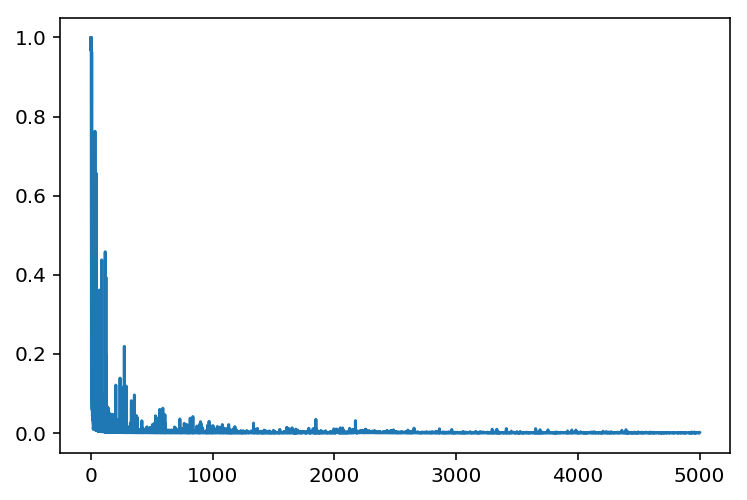

Value function
---------------------------
 0.54| 0.75| 1.00| 0.00|
---------------------------
 0.35| 0.00| 0.76| 0.00|
---------------------------
 0.19| 0.30| 0.49| 0.30|

Policy
---------------------------
  →  |  →  |  →  |     |
---------------------------
  ↑  |     |  ↑  |     |
---------------------------
  ↑  |  →  |  ↑  |  ←  |


In [16]:
grid = create_grid(step_cost=-0.1)
policy = random_policy(grid)

# Q(s,a) and returns are initialized
Q = {}
returns = {}
states = grid.all_states()
for s in states:
    if s in grid.actions:
        Q[s] = {}
        for a in Grid.possible_actions:
            Q[s][a] = 0
            returns[(s,a)] = []
    else:
        pass
    
deltas = []
for t in range(5000):
    # A new episode is generated using pi
    biggest_change = 0
    states_actions_returns = play_game_no_es(grid, policy)

    # Calculo de Q(s,a)
    seen_state_action_pairs = set()
    
    for s, a, G in states_actions_returns:
        # Check if s has already visited
        # The evaluation is done only in the first visit
        sa = (s, a)
        if sa not in seen_state_action_pairs:
            old_q = Q[s][a]
            returns[sa].append(G)
            Q[s][a] = np.mean(returns[sa])
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
            seen_state_action_pairs.add(sa)
            
    deltas.append(biggest_change)

    # calculate the new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
        a, _ = max_dict(Q[s])
        policy[s] = a

plt.plot(deltas)
plt.show()

# Locate the optimal status value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

print_value_policy(V, policy, grid)